In [1]:
"""
Created on Thu Mar  17 10:14:53 2022

@author: Katrin Blondal, Bjarne Kreitz, Franklin Goldsmith, School of Engineering, Brown University
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import csv
import numpy
from decimal import Decimal

plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.titlesize']=16
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['legend.edgecolor']='k'

#Required constants
kb= 1.380649e-23 #ct.boltzmann units: m2kg/s2/K
h= 6.62607009e-34 #ct.planck units: Js
R= 8.3144621 #ct.gas_constant/1e3 units: J/mol/K

#read the files that contain the entropy and the partition function as 
# a function of temperature

TST=pd.read_csv("Transition_State/HCCH3_TST.txt", sep="\t", header=1)
TST.columns=['Temp', 'q']

initial=pd.read_csv("Initial_State/HCCH3_initial.txt", sep="\t", header=1)
initial.columns=['Temp', 'q']

#This is the difference in entropy between transition state and initial state
reactant_q=initial.q
sp_q=TST.q

T=TST.Temp

#These are the energies of the initial state from the DFT calculation
SPE_initial=-119180.7953
ZPE_initial=1.372

#Subtract the ZPE from SPE
PE_initial=SPE_initial+ZPE_initial

#These are the energies of the transition state from the DFT calculation
SPE_TST=-119180.2037
ZPE_TST=1.247

#Subtract the ZPE from SPE
PE_TST=SPE_TST+ZPE_TST

#The change in the enthalpy of is the difference in the energy of the transition and final state, convert to kJ/mol
Delta_E=PE_TST-PE_initial
#print(Delta_E)
Delta_E*=96.485
print(Delta_E)

#make a function to evaluate the rate constant at all temperatures
#x is the variable for the temperature
#y is the variable for the partition functions
def k(x,y):
    return kb*x/h*y*np.exp(-Delta_E*1e3/R/x)

#Evaluate the function for all temperatures and the corresponding entropies
k=np.array(k(T,sp_q/reactant_q))
T_reciprok=np.array(1/T*1000)

45.01990099997529


# Introduction

This is the equation for the canonical transition state theory (TST) rate coefficient:
$$ k_\text{TST}\left( T \right) = \frac{k_BT}{h} \frac{Q^\ddagger \left(T\right)}{Q_R\left(T\right)}e^{-E_0 / k_B T}$$

And this is the equation for the modified Arrhenius expression for the rate coefficient:
    $$ k \left(T\right) = A \left( \frac{T}{T_\text{ref}} \right)^n e^{-E_a / k_B T} $$
    Frequently, we wish to fit the coefficients $A$, $n$, and $E_a$.

Our goal is to fit the three modified-Arrhenius parameters $A$, $n$, and $E_a$ to these data.

Let's specify the reference temperature: $T_\text{ref} = 1$ [K]

In [2]:
def sse_in_log(k1, k2):
    square_residual=(np.log(k1)-np.log(k2))**2.0
    sum_square_error=sum(square_residual)
    return sum_square_error

# Linearized system

As an alternative to the previous example, note that we can linearize the Arrhenius expression as follows:
   $$ \ln \left( k \right) = \ln \left( A \right) + n \ln \left( T \right) - \frac{E_a}{RT} $$

Thus, by taking the natural log of our rate coefficient data, we now have a system that is linear in terms of the three coefficients $A$, $n$, and $E_A$. Accordingly, we can pose the problem as a linear system:
$$\mathbf{A} \mathbf{x} = \mathbf{b}$$
(since we've already assigned the variable $A$ once, I will use the matrix $\mathbf{Y}$ instead)
$$\mathbf{Y} \mathbf{x} = \mathbf{b}$$
where:
$$ \mathbf{Y} = \left[ \begin{array}{ccc}
1 & \ln \left( T_1 \right) & \frac{-1}{R T_1} \\
1 & \ln \left( T_2 \right) & \frac{-1}{R T_2} \\
\vdots & \vdots & \vdots \\
1 & \ln \left( T_n \right) & \frac{-1}{R T_n}
\end{array}\right] $$
$$ \mathbf{x} = \left[ \begin{array}{c}
ln(A) \\
n \\ 
E_a
\end{array}\right] $$
and 
$$ \mathbf{b} = \left[ \begin{array}{c}
\ln \left( k \left( T_1 \right)  \right) \\
\ln \left( k \left( T_2 \right)  \right) \\
\vdots \\
\ln \left( k \left( T_n \right)  \right) \\
\end{array}\right] $$

Because we have more data than parameters, no exact solution is possible, so our goal is the find the best possible set, $\mathbf{\hat{x}}$. We can solve for the unknown $\mathbf{\hat{x}}$ by left multiplying both the left- and right-hand side with the transpose of $\mathbf{Y}$, $\mathbf{Y}^\mathbf{T}$, then left multiplying both sides by the inverse of the resulting square matrix:
$$ \mathbf{\hat{x}} = \left(\mathbf{Y}^\mathbf{T} \mathbf{Y} \right)^{-1} \left( \mathbf{Y}^\mathbf{T} \mathbf{b} \right) $$

Now, define the matrix $\mathbf{Y}$. Note that, according to our definition above, we need for the dimensions of $\mathbf{A}$ to be $N_T \times 3$ (where $N_T$ is the number of temperatures). Somewhat confusingly, we will define it instead as a $3\times N_T$ matrix. In other words, our initial declaration is actually the transpose.

Of course, numpy already has a pre-programmed regression function, you can simply call the function $\texttt{lstsq}$:

In [3]:
YT = np.array( [ np.ones( len(T) ), np.log(T), -1.0 / R / T ],dtype=np.float64 ) #this is transpose of our Y
Y = YT.transpose() #this is the desired Y
b = np.log(k)
x = np.linalg.lstsq(Y, b, rcond=None)[0]
#Return the least-squares solution to a linear matrix equation.
print(x)

[2.55660899e+01 5.98246567e-01 4.53010515e+04]


Now we can unpack the solution vector $\mathbf{\hat{x}}$

In [4]:
A_lin = np.exp(x[0])
n_lin = x[1]
Ea_lin = x[2]
#subscript _lin is used to denote the result obtained from using linearized system
print("Here are the results: A=%.3E\tn=%.3F\tEa=%.3F"%(A_lin, n_lin, Ea_lin))
k_lin = A_lin * T**n_lin * np.exp(-Ea_lin / R / T)

Here are the results: A=1.268E+11	n=0.598	Ea=45301.051


In some cases it might be sufficient or preferred to make a regression only for the regular Arrhenius expression

In [5]:
log_k=np.log(k)
#Reshape the arrays for the fitting procedure
log_k=log_k.reshape(len(log_k),1)
T_reciprok=T_reciprok.reshape(len(T_reciprok),1)

from sklearn.linear_model import LinearRegression

#Linear regression of an Arrhenius expression to the calculated rate constant
model =LinearRegression(fit_intercept=True)
model.fit(T_reciprok,log_k)
yfit=model.predict(log_k)
Ea_R=float(model.coef_[0])
ln_A=float(model.intercept_[0])
Ea=R*-Ea_R
A=np.exp(ln_A)
#x=np.linspace(0.5,3.5,100)
Fit=Ea_R*1000./T+ln_A
print("Here are the results: A=%.3E\tEa=%.3F"%(A, Ea_lin))

Here are the results: A=1.323E+13	Ea=45301.051


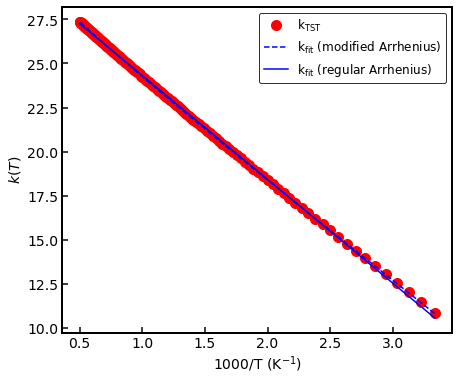

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(1000./T, np.log(k), 'ro', label='$\mathrm{k_{TST}}$')
ax.plot(1000./T, np.log(k_lin), 'b--', label='$\mathrm{k_{fit}\  (modified\ Arrhenius)}$')
ax.plot(1000./T, Fit, 'b', label='$\mathrm{k_{fit}\ (regular\ Arrhenius)}$')
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('1000/T (K$^{-1}$)', fontsize=14)
ax.set_ylabel('$k(T)$', fontsize=14);

sum of square error in log space:

In [7]:
sse_lin = sse_in_log(k_lin,k)
print("modified Arrhenius: %.2E"%(sse_lin))

#Compute the sum of square errors for the regular Arrhenius
score=model.score(T_reciprok,log_k)
print("regular Arrhenius: %.2E"%(1-score))

modified Arrhenius: 1.37E-02
regular Arrhenius: 3.86E-04


In [8]:
#Surface site density for Pt(111) in mol/m2
Gamma=2.48292e-5

#convert A to right units:
A_surf = A_lin/(Gamma**2.0)
print("A for the modified Arrhenius approach: A=%.3E"%(A_surf)) #in units of m4 mol-2 s-1
A_surf_regular = A/(Gamma**2.0)
print("A for the regular Arrhenius approach: A=%.3E"%(A_surf_regular)) #in units of m4 mol-2 s-1

A for the modified Arrhenius approach: A=2.057E+20
A for the regular Arrhenius approach: A=2.146E+22
